In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import xarray as xr
import pandas as pd
import os

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

In [2]:
'''
for f in os.listdir('../reference/rain_gauge_preds'): 
    st = 'GOES_s2020030305'
    if (f[:len(st)]==st):
        raw_data = xr.load_dataset(os.path.join('../reference/rain_gauge_preds/',f))
        check = np.sum([np.isnan(raw_data.data_vars[d]).any() for d in list(raw_data.data_vars.keys())])
        fig, ax = plt.subplots(4,2, figsize=(8,12))
        fig.suptitle(f+' num channels with nans ' + str(check))
        k=0
        for i in range(4):
            for j in range(2):
                ax[i,j].imshow(raw_data[list(raw_data.data_vars.keys())[k]])
                k+=1
'''

"\nfor f in os.listdir('../reference/rain_gauge_preds'): \n    st = 'GOES_s2020030305'\n    if (f[:len(st)]==st):\n        raw_data = xr.load_dataset(os.path.join('../reference/rain_gauge_preds/',f))\n        check = np.sum([np.isnan(raw_data.data_vars[d]).any() for d in list(raw_data.data_vars.keys())])\n        fig, ax = plt.subplots(4,2, figsize=(8,12))\n        fig.suptitle(f+' num channels with nans ' + str(check))\n        k=0\n        for i in range(4):\n            for j in range(2):\n                ax[i,j].imshow(raw_data[list(raw_data.data_vars.keys())[k]])\n                k+=1\n"

In [68]:
data = xr.load_dataset('../reference/rain_gauge_preds/1/2020120107.nc')

In [69]:
data

<xarray.Dataset>
Dimensions:                  (x: 1024, y: 1024)
Dimensions without coordinates: x, y
Data variables:
    xception_posterior_mean  (y, x) float32 1.635 1.65 ... 0.0005524 0.0005524
    xception_Q0.95           (y, x) float32 4.811 4.842 ... 0.0009571 0.0009571
    xception_Q0.99           (y, x) float32 8.824 8.883 ... 0.0009933 0.0009933
    mlp_posterior_mean       (y, x) float32 2.554 2.367 ... 0.0005516 0.0005516
    mlp_Q0.95                (y, x) float32 9.297 8.683 ... 0.0009579 0.0009579
    mlp_Q0.99                (y, x) float32 20.38 19.34 ... 0.0009932 0.0009932
Attributes:
    ind_extent:   [1344 2217 2368 1193]
    area_extent:  [  -46092.39762437 -3452921.78725195  4058135.00823285   65...
    shape:        [1024 1024]
    start:        2020-12-01 06:00:00
    end:          2020-12-01 07:00:00
    datetimes:    ['[datetime.datetime(2020, 12, 1, 6, 0, 13), datetime.datet...

In [70]:
np.isnan(data.xception_posterior_mean).any()

<xarray.DataArray 'xception_posterior_mean' ()>
array(False)

In [81]:
np.max(data.xception_posterior_mean.values)

35.917973

In [82]:
np.max(data.mlp_posterior_mean.values)

16.95582

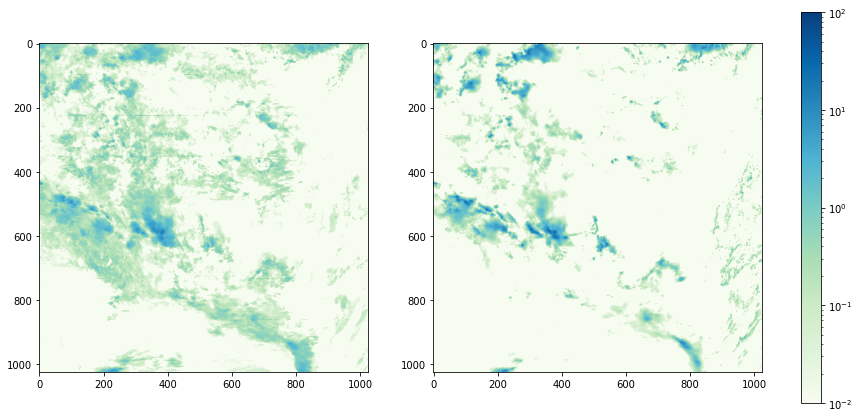

In [71]:
precip_norm = LogNorm(1e-2, 1e2)
fig, ax = plt.subplots(1, 2, figsize=(14,8))
m = ax[0].imshow(data.mlp_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

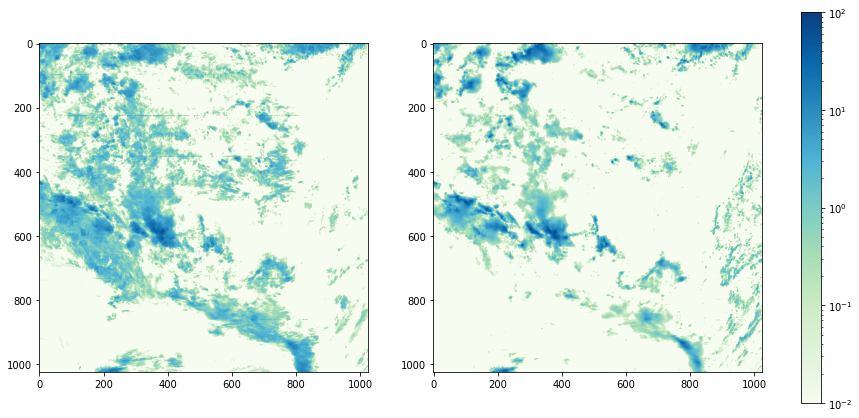

In [72]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
m = ax[0].imshow(data['mlp_Q0.95'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data['xception_Q0.95'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

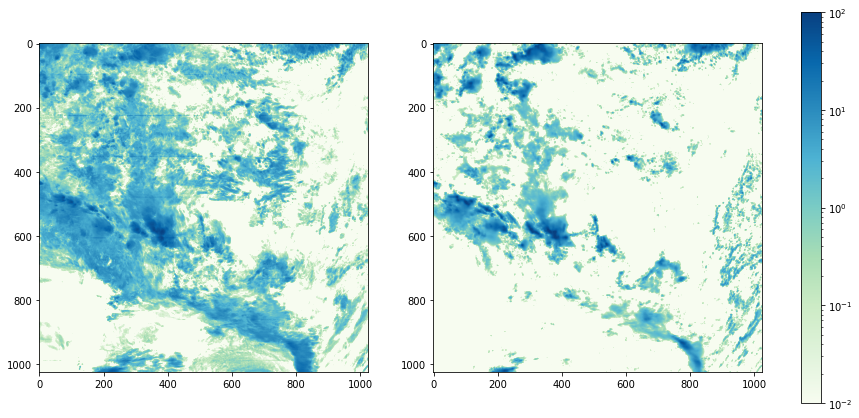

In [73]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
m = ax[0].imshow(data['mlp_Q0.99'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
b = ax[1].imshow(data['xception_Q0.99'], norm=precip_norm, cmap=plt.get_cmap('GnBu'))
fig.colorbar(b, ax=ax, fraction=0.025)

In [74]:
def get_gauge_locations(path_to_rain_gauge_data, region_ind_extent):
    #region_corners_idx_low, __, __, region_corners_idy_low = region_ind_extent
    lonlats = pd.read_pickle(os.path.join(path_to_rain_gauge_data,'rain_gauge_locs.pckl'))
    colrows = []
    for lon, lat in zip(lonlats['lon'], lonlats['lat']):
        col, row = area_def.lonlat2colrow(lon, lat)
        #colrows.append((col-region_corners_idx_low, row-region_corners_idy_low))
        colrows.append((col, row))

    colrows = pd.DataFrame(colrows, columns = ['cols', 'rows'])

    return(colrows)

In [75]:
path_to_rain_gauge_data = '../reference/'
region_ind_extent = data.ind_extent
area_path='../dataset/downloads/files/areas.yaml'
area_def = load_area(area_path, 'full_disk')
gauge_locs = get_gauge_locations(path_to_rain_gauge_data, region_ind_extent)

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [76]:
#fig, ax = plt.subplots(figsize=(8,8))
#ax.invert_yaxis()
#plt.scatter(gauge_locs.cols, gauge_locs.rows)

/home/ingrid/anaconda/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


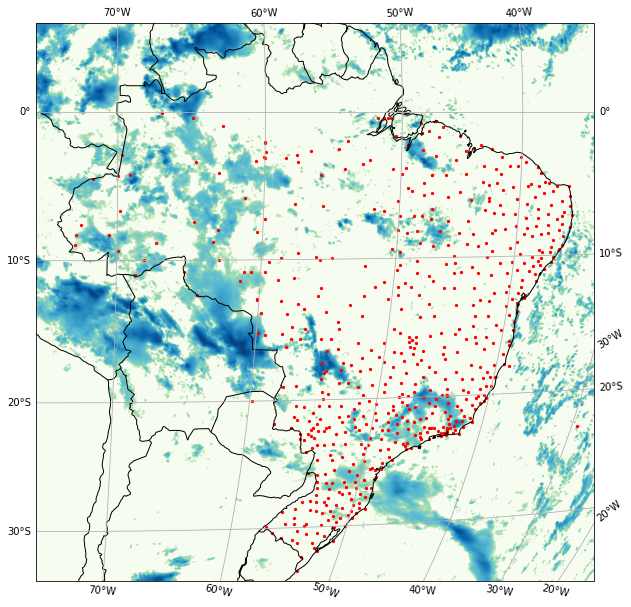

In [77]:
projcoords_x, projcoords_y = area_def.get_proj_vectors()
projcoords_mat_x, projcoords_mat_y = area_def.get_proj_coords()

area_def_ext_region = area_def.copy(area_extent = data.area_extent,
                                                  height = data.shape[0], 
                                                  width = data.shape[1])
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))
ax.scatter(x=projcoords_mat_x[gauge_locs.rows, gauge_locs.cols], 
           y=projcoords_mat_y[gauge_locs.rows, gauge_locs.cols], transform=crs, s=5, color='red')
ax.imshow(data['xception_Q0.99'], extent=crs.bounds, origin='upper', norm=precip_norm, transform=crs, cmap=plt.get_cmap('GnBu'))
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [56]:
'''
ind=0
single_obs_posterior_mean = []
single_obs95 = []
single_obs99 = []
region_corners_idx_low, __, __, region_corners_idy_low = region_ind_extent
for i in range(1,2):
    data = xr.load_dataset('../reference/rain_gauge_preds/20201201'+str(i).zfill(2)+'.nc')
    fig, ax = plt.subplots(num=i)
    ax.imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))
    ax.set_title(str(i))
    single_obs_posterior_mean.append(data.xception_posterior_mean[gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])
    single_obs95.append(data['xception_Q0.95'][gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])
    single_obs99.append(data['xception_Q0.99'][gauge_locs.cols[ind]-region_corners_idx_low, 
                                                   gauge_locs.rows[ind]-region_corners_idy_low])

''' 

"\nind=0\nsingle_obs_posterior_mean = []\nsingle_obs95 = []\nsingle_obs99 = []\nregion_corners_idx_low, __, __, region_corners_idy_low = region_ind_extent\nfor i in range(1,2):\n    data = xr.load_dataset('../reference/rain_gauge_preds/20201201'+str(i).zfill(2)+'.nc')\n    fig, ax = plt.subplots(num=i)\n    ax.imshow(data.xception_posterior_mean, norm=precip_norm, cmap=plt.get_cmap('GnBu'))\n    ax.set_title(str(i))\n    single_obs_posterior_mean.append(data.xception_posterior_mean[gauge_locs.cols[ind]-region_corners_idx_low, \n                                                   gauge_locs.rows[ind]-region_corners_idy_low])\n    single_obs95.append(data['xception_Q0.95'][gauge_locs.cols[ind]-region_corners_idx_low, \n                                                   gauge_locs.rows[ind]-region_corners_idy_low])\n    single_obs99.append(data['xception_Q0.99'][gauge_locs.cols[ind]-region_corners_idx_low, \n                                                   gauge_locs.rows[ind]-region_cor

In [14]:
#plt.plot(single_obs_posterior_mean)
#plt.plot(single_obs95)
#plt.plot(single_obs99)
#plt.show()